# Setting up the System

## To run in local system

In [97]:
!pip install openai
!pip install python-dotenv
!pip install datasets

In [98]:
import openai
from google.colab import userdata

## To run in Google Colab

In [99]:
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY_1')

In [100]:
import openai
openai.api_key = OPENAI_API_KEY

# MedQA Casestudy


Link to the dataset:https://huggingface.co/datasets/bigbio/med_qa

In [101]:
from datasets import load_dataset
medqa = load_dataset("bigbio/med_qa", download_mode="force_redownload")
medqa

Generating train split:   0%|          | 0/10178 [00:00<?, ? examples/s]

/root/.cache/huggingface/datasets/downloads/extracted/dc86b4af1d384a2680873fd3704ef3e09f2446bcfbf86dcc7655b8be63682696/data_clean/questions/US/train.jsonl


Generating test split:   0%|          | 0/1273 [00:00<?, ? examples/s]

/root/.cache/huggingface/datasets/downloads/extracted/dc86b4af1d384a2680873fd3704ef3e09f2446bcfbf86dcc7655b8be63682696/data_clean/questions/US/test.jsonl


Generating validation split:   0%|          | 0/1272 [00:00<?, ? examples/s]

/root/.cache/huggingface/datasets/downloads/extracted/dc86b4af1d384a2680873fd3704ef3e09f2446bcfbf86dcc7655b8be63682696/data_clean/questions/US/dev.jsonl


DatasetDict({
    train: Dataset({
        features: ['meta_info', 'question', 'answer_idx', 'answer', 'options'],
        num_rows: 10178
    })
    test: Dataset({
        features: ['meta_info', 'question', 'answer_idx', 'answer', 'options'],
        num_rows: 1273
    })
    validation: Dataset({
        features: ['meta_info', 'question', 'answer_idx', 'answer', 'options'],
        num_rows: 1272
    })
})

In [102]:
tr = medqa['train'].to_pandas()
tr['options'] = tr['options'].apply(lambda x: "\n".join([f"({i['key']}: {i['value']})" for i in x]))
tr.head()

,meta_info,question,answer_idx,answer,options
0,step2&3,A 23-year-old pregnant woman at 22 weeks gesta...,E,Nitrofurantoin,(A: Ampicillin)\n(B: Ceftriaxone)\n(C: Ciprofl...
1,step2&3,A 3-month-old baby died suddenly at night whil...,A,Placing the infant in a supine position on a f...,(A: Placing the infant in a supine position on...
2,step1,A mother brings her 3-week-old infant to the p...,A,Abnormal migration of ventral pancreatic bud,(A: Abnormal migration of ventral pancreatic b...
3,step1,A pulmonary autopsy specimen from a 58-year-ol...,A,Thromboembolism,(A: Thromboembolism)\n(B: Pulmonary ischemia)\...
4,step1,A 20-year-old woman presents with menorrhagia ...,E,Von Willebrand disease,(A: Factor V Leiden)\n(B: Hemophilia A)\n(C: L...


In [191]:
def multiple_qas(tr, num_qsns=5, examples=0):
    # get random 5 qsns and answers
    tr = tr.sample(num_qsns)
    qsn, opt, ans = tr.question.values, tr.options.values, tr.answer_idx.values
    prompts =""
    ex=0
    for q in qsn:
      if ex < min(examples,num_qsns):
          prompts += (f'''\nQuestion:{q}\n\n Options:{opt[ex]}\n\n Answer:{ans[ex]}\n\n''')
          ex+=1
      else:
        prompts += (f'''\nQuestion:{q}\n\n Options:{opt[ex]}\n\n Answer:?\n\n''')
        ex+=1
    return prompts


def qsn_answer(tr, **kwargs):
    qsn, ans = multiple_qas(tr, **kwargs)
    print(qsn)
    if ans is None:
          return f'''Question:{qsn}\n Answer:'''
    return f'''Question:{qsn}\n Answer:{ans}'''

In [192]:
def get_response(messages,model="gpt-3.5-turbo"):

    response = openai.chat.completions.create(
        model=model,
        messages=messages)

    return response.choices[0].message.content

Define the System role

In [193]:
system_role = "You are a helpful assistant that answers multiple choice questions about medical knowledge."

# One Shot Prompting

In [194]:
user_prompt = multiple_qas(tr, num_qsns=5,examples=1)

In [195]:
print(user_prompt)


Question:The incidence of a relatively benign autosomal recessive disease, X, is 1 in 25 in the population. Assuming that the conditions for Hardy Weinberg Equilibrium are met, what is the probability that a male and female, who are carriers, will have a child expressing the disease?

 Options:(A: 1/4)
(B: 1/5)
(C: 4/5)
(D: 1/25)
(E: 8/25)

 Answer:A


Question:A 32-year-old woman comes to the physician because of a 3-month history of irregular menses, milky discharge from her nipples, fatigue, and weight gain. Menses occur at irregular 25–40-day intervals and last 1–2 days with minimal flow. 5 months ago, she was started on clozapine for treatment of schizophrenia. She has hypothyroidism but has not been taking levothyroxine over the past 6 months. Visual field examination show no abnormalities. Her serum thyroid-stimulating hormone is 17.0 μU/mL and serum prolactin is 85 ng/mL. Which of the following is the most likely explanation for the nipple discharge in this patient?

 Options:

In [196]:
messages=[{'role':'system','content':system_role},
          {'role':'user','content':user_prompt}
          ]

In [197]:
print("##############################")
print("GPT-3.5-TURBO")
print(get_response(messages)) # GPT-3.5-turbo
print("##############################")

print("##############################")
print("GPT-4")
print(get_response(messages, model="gpt-4")) #GPT-4

##############################
GPT-3.5-TURBO
Question:A 32-year-old woman comes to the physician because of a 3-month history of irregular menses, milky discharge from her nipples, fatigue, and weight gain. Menses occur at irregular 25–40-day intervals and last 1–2 days with minimal flow. 5 months ago, she was started on clozapine for the treatment of schizophrenia. She has hypothyroidism but has not been taking levothyroxine over the past 6 months. Visual field examination shows no abnormalities. Her serum thyroid-stimulating hormone is 17.0 μU/mL, and serum prolactin is 85 ng/mL. Which of the following is the most likely explanation for the nipple discharge in this patient?

Options:(A: Hypothyroidism)
(B: Prolactinoma)
(C: Thyrotropic pituitary adenoma)
(D: Ectopic prolactin production)
(E: Adverse effect of medication)

Answer:E (Adverse effect of medication)

Question:A 51-year-old man presents for evaluation of a 3-week history of fatigue and shortness of breath. One year ago, a 

# Few Shot Prompting

In [198]:
user_prompt = multiple_qas(tr, num_qsns=5,examples=3)
user_prompt += f'''\n Provide the answer as an option to the missing answers above'''
print(user_prompt)


Question:A 27-year-old woman, gravida 2, para 1, at 38 weeks' gestation comes to the emergency department in active labor. She received all of her prenatal care for this pregnancy. Pregnancy and delivery of her first child were uncomplicated. The patient's blood type is Rh-negative. Four hours after arrival, a healthy 3650-g (8-lb) female newborn is delivered. Delivery of the fetus is followed by placental retention and heavy vaginal bleeding. One hour later, the placenta is manually removed and the bleeding ceases. The mother's temperature is 36.7°C (98.1°F), pulse is 90/min, and blood pressure is 110/60 mm Hg. Examination shows blood on the vulva, the introitus, and on the medial aspect of each thigh. The neonate's blood type is Rh-positive. A single dose of anti-D immune globulin is administered. Which of the following is the most appropriate next step in management?

 Options:(A: Perform flow cytometry)
(B: Perform rosette test)
(C: Perform Kleihauer-Betke test)
(D: Administer add

In [199]:
messages=[{'role':'system','content':system_role},
          {'role':'user','content':user_prompt}
          ]

In [200]:
print("##############################")
print("GPT-3.5-TURBO")
print(get_response(messages)) # GPT-3.5-turbo
print("##############################")

print("##############################")
print("GPT-4")
print(get_response(messages, model="gpt-4")) #GPT-4

##############################
GPT-3.5-TURBO
Question: A 65-year-old woman comes to the physician for an 18-month history of gradual enlargement of her fingertips and a 2-month history of a hoarse voice. She has had decreased appetite after a respiratory tract infection 3 months ago and an 8-kg (17.6-lb) weight loss during this period. The patient has never smoked. She was diagnosed with obstructive sleep apnea 10 years ago and uses a CPAP mask at night. She retired from her job as an administrative assistant at a local college 5 years ago. She appears tired. Her vital signs are within normal limits. Physical examination shows increased convexity of the nail fold and painful swelling of the soft tissue of her fingers and ankles. There is no discoloration of her lips and oral mucosa. There is faint wheezing in the right upper lung field. This patient's condition is most likely associated with which of the following findings?

Options:
(A: Increased serum ADH)
(B: Miosis)
(C: Increased s

# Zero Shot Prompting

In [201]:
user_prompt = multiple_qas(tr, num_qsns=5,examples=0)
user_prompt += f'''\n Provide the answer as an option to the missing answers above'''
print(user_prompt)


Question:A 63-year-old man with alpha-1-antitrypsin deficiency is brought to the emergency department 1 hour after his daughter found him unresponsive. Despite appropriate care, the patient dies. At autopsy, examination of the lungs shows enlargement of the airspaces in the respiratory bronchioles and alveoli. Destruction of which of the following cells is the most likely cause of these findings?

 Options:(A: Non-ciliated cuboidal cells)
(B: Type I pneumocytes)
(C: Type II pneumocytes)
(D: Ciliated cuboidal cells)
(E: Ciliated columnar cells)

 Answer:?


Question:A 2-year-old girl is brought to the emergency department by her mother after an episode of turning blue on the playground. The mother states that the girl starting crying, and her fingers and hands turned blue. On examination, the patient is playful and in no apparent distress. She is afebrile and the vital signs are stable. The lungs are clear to auscultation bilaterally with no evidence of respiratory distress. There is a

In [202]:
messages=[{'role':'system','content':system_role},
          {'role':'user','content':user_prompt}
          ]

In [204]:
print("##############################")
print("GPT-3.5-TURBO")
print(get_response(messages)) # GPT-3.5-turbo
print("##############################")

print("##############################")
print("GPT-4")
print(get_response(messages, model="gpt-4")) #GPT-4

##############################
GPT-3.5-TURBO
Answer for the first question:
(B: Type I pneumocytes)

Answer for the second question:
(C: Failure of the ductus arteriosus to regress)

Answer for the third question:
(B: Slit lamp examination)

Answer for the fourth question:
(C: Acute pancreatitis)

Answer for the fifth question:
(B: Lead time bias; Golem effect)
##############################
##############################
GPT-4
Question 1: Answer: (B: Type I pneumocytes)

Question 2: Answer: (D: Failure of the aorticopulmonary septum to spiral)

Question 3: Answer: (B: Slit lamp examination)

Question 4: Answer: (C: Acute pancreatitis)

Question 5: Answer: (A: Lead time bias; Pygmalion effect)


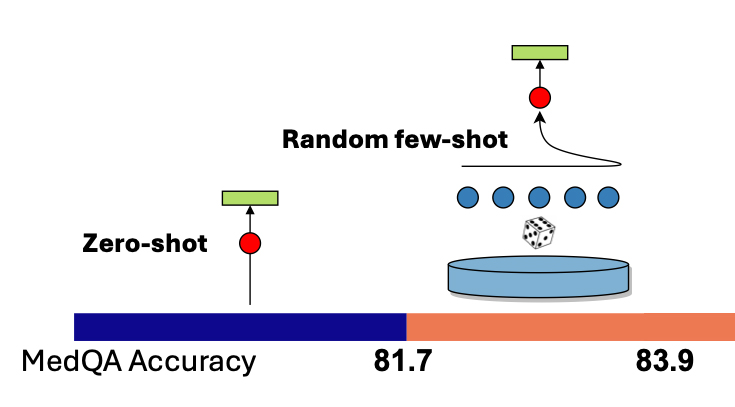